In [1]:
import os

import torch
from hydra import compose, initialize
from torch.utils.data import DataLoader

from src.components.dvi.cmcd import CMCD
from src.utils.grid import (compute_bd, compute_jsd, compute_lmpl, create_grid,
                            eval_dist_on_grid, eval_hist_on_grid,
                            eval_kde_on_grid)
from src.utils.load import load_dvinp
from src.utils.visualize import visualize_dvinp_both, visualize_vals_on_grid_2d

In [2]:
try:
    import torch_directml
    device = torch_directml.device() 
except ImportError:
    device = torch.device("cpu") 
print(device)

cpu


In [3]:
dir = "../pretrained" # "../models/deft-cherry-10"  

In [5]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="cfg")

    dvinp, trainer = load_dvinp(cfg, dir, device)

    # dvinp.cdvi = CMCD(
    #     device=device, 
    #     z_dim=cfg.common.z_dim,
    #     num_steps=cfg.dvi_process.num_steps,
    #     control=None,
    # )

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 435738.69it/s]


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options 
	(1) Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch._utils._rebuild_device_tensor_from_numpy was not an allowed global by default. Please use `torch.serialization.add_safe_globals([_rebuild_device_tensor_from_numpy])` to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

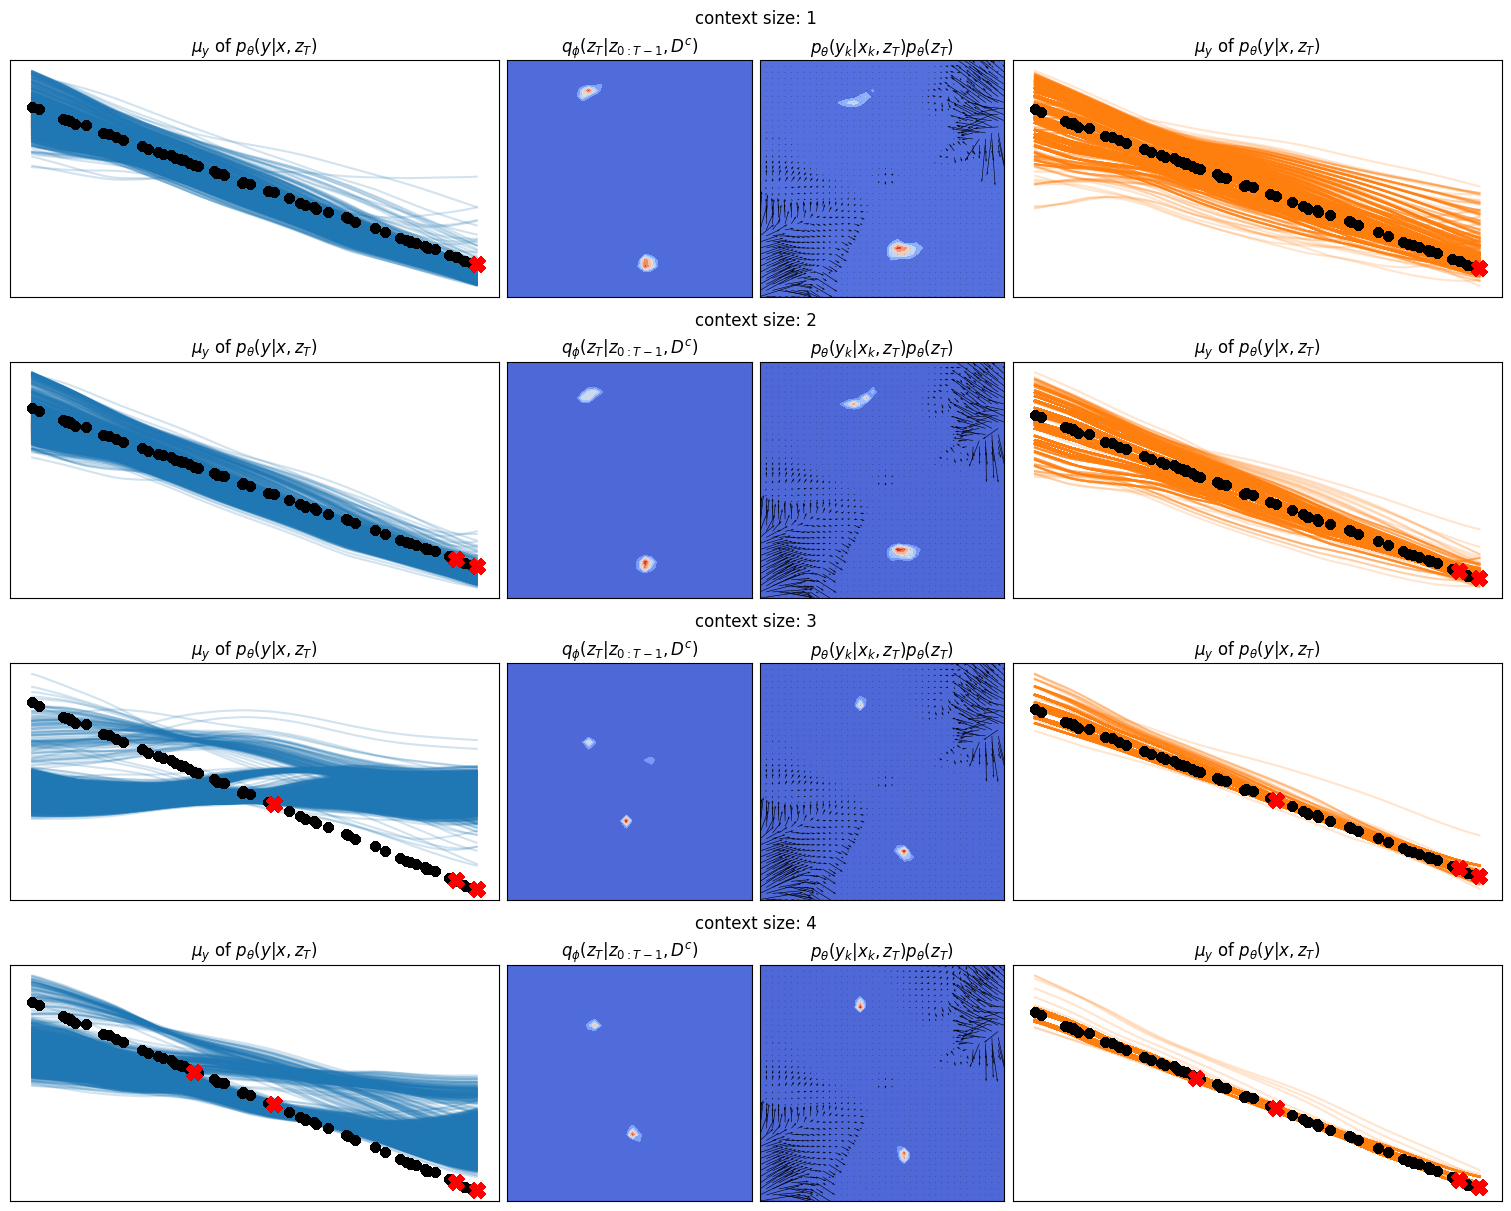

In [28]:
max_context_size = 4
num_samples = 1600
gen_dataloader = DataLoader(trainer.dataset, 1, True)

targets, samples = visualize_dvinp_both(
    device=device,
    dvinp=dvinp,
    dataloader=gen_dataloader,
    num_samples=num_samples,
    max_context_size=max_context_size,
    ranges=[(-5, 5), (-5, 5)],
)

In [8]:
!jupyter nbconvert --to script eval_bml.ipynb

[NbConvertApp] Converting notebook eval_bml.ipynb to script
[NbConvertApp] Writing 1614 bytes to eval_bml.py
